# Task 2: Exploratory Data Analysis (EDA)  
**10 Academy Week 10 Challenge**

**Author:** Dororo  
**Date:** January 31, 2026

**Objectives:**
- Visualize trends (account ownership, mobile money, digital payments)
- Analyze gaps (gender, urban/rural if available)
- Overlay events on timelines
- Correlations with enablers (mobile/internet penetration, etc.)
- Document 5+ key insights

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED_DIR = os.path.join(PROJECT_ROOT, 'data', 'processed')
REPORTS_DIR = os.path.join(PROJECT_ROOT, 'reports', 'figures')

os.makedirs(REPORTS_DIR, exist_ok=True)

enriched_path = os.path.join(PROCESSED_DIR, 'enriched_fi_unified_data.csv')
df = pd.read_csv(enriched_path, low_memory=False)

print("Loaded enriched data shape:", df.shape)
print(df['record_type'].value_counts())

Loaded enriched data shape: (55, 35)
record_type
observation    37
event          12
target          3
impact_link     3
Name: count, dtype: int64


In [2]:
obs = df[df['record_type'] == 'observation'].copy()
obs['observation_date'] = pd.to_datetime(obs['observation_date'], errors='coerce')
obs['year'] = obs['observation_date'].dt.year

print("Observation years:", sorted(obs['year'].dropna().unique()))

Observation years: [np.int32(2014), np.int32(2017), np.int32(2021), np.int32(2023), np.int32(2024), np.int32(2025)]


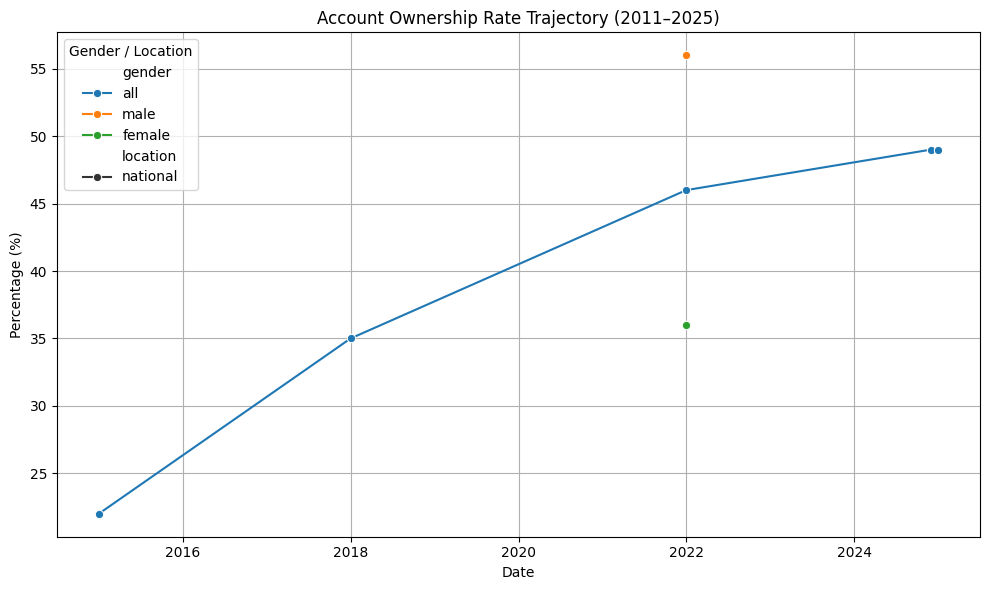

In [3]:
acc_own = obs[obs['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')

plt.figure(figsize=(10, 6))
sns.lineplot(data=acc_own, x='observation_date', y='value_numeric', marker='o', hue='gender', style='location')
plt.title('Account Ownership Rate Trajectory (2011–2025)')
plt.ylabel('Percentage (%)')
plt.xlabel('Date')
plt.grid(True)
plt.legend(title='Gender / Location')
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, 'account_ownership_trajectory.png'))
plt.show()

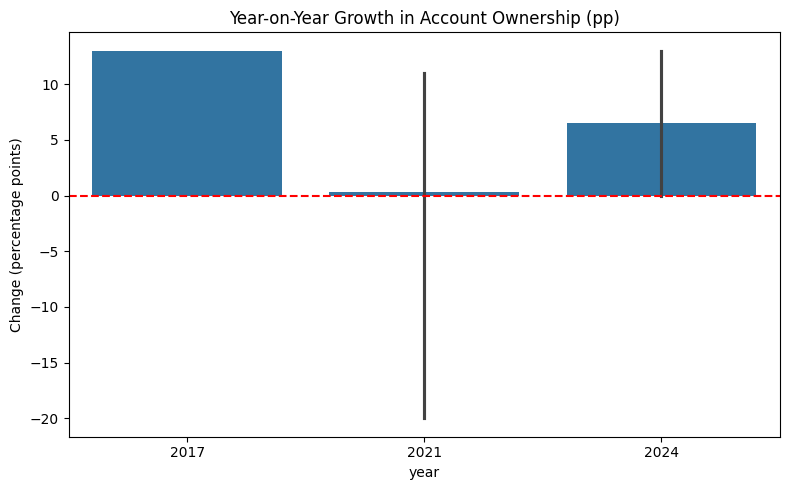

In [4]:
acc_own['growth_pp'] = acc_own['value_numeric'].diff()
growth_df = acc_own[['year', 'growth_pp']].dropna()

plt.figure(figsize=(8, 5))
sns.barplot(data=growth_df, x='year', y='growth_pp')
plt.title('Year-on-Year Growth in Account Ownership (pp)')
plt.ylabel('Change (percentage points)')
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, 'growth_rates.png'))
plt.show()

<Figure size 900x600 with 0 Axes>

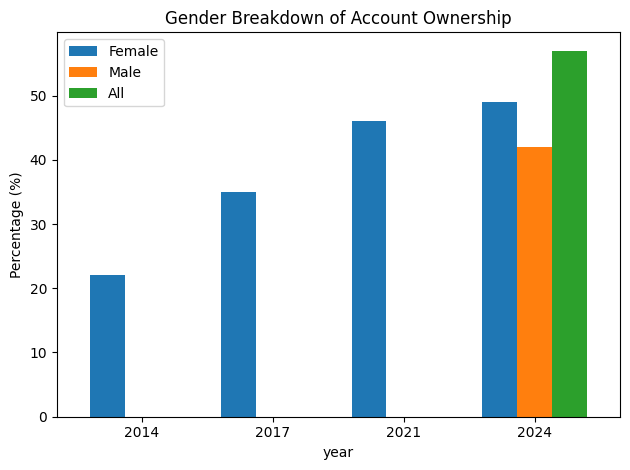

In [5]:
gender_data = obs[obs['indicator_code'].isin(['ACC_OWN_MALE', 'ACC_OWN_FEMALE', 'ACC_OWNERSHIP'])]
gender_pivot = gender_data.pivot_table(index='year', columns='indicator_code', values='value_numeric')

plt.figure(figsize=(9, 6))
gender_pivot.plot(kind='bar', width=0.8)
plt.title('Gender Breakdown of Account Ownership')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(['Female', 'Male', 'All'])
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, 'gender_gap.png'))
plt.show()

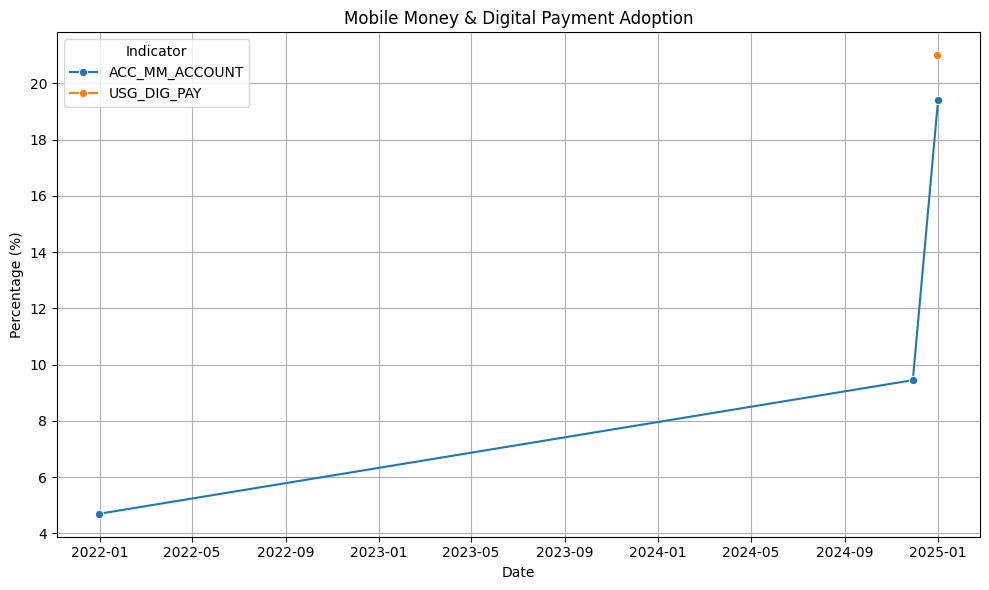

In [6]:
mm_dig = obs[obs['indicator_code'].isin(['ACC_MM_ACCOUNT', 'USG_DIG_PAY'])]

plt.figure(figsize=(10, 6))
sns.lineplot(data=mm_dig, x='observation_date', y='value_numeric', hue='indicator_code', marker='o')
plt.title('Mobile Money & Digital Payment Adoption')
plt.ylabel('Percentage (%)')
plt.xlabel('Date')
plt.grid(True)
plt.legend(title='Indicator')
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, 'mobile_digital_trends.png'))
plt.show()

Pivoted enablers data (after aggregation):


indicator_code,ACC_INTERNET_PEN,ACC_MOBILE_PEN,ACC_OWNERSHIP
observation_date,,,
2014-12-31,NaN,NaN,22.0
2017-12-31,NaN,NaN,35.0
2021-12-31,NaN,NaN,36.0
2024-11-29,NaN,NaN,49.0
2024-12-31,NaN,NaN,49.0
2025-12-31,21.7,68.4,NaN


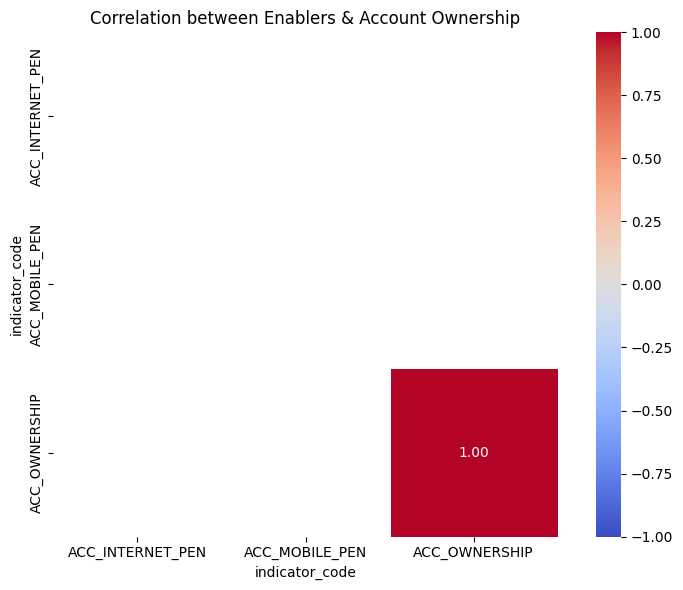

In [10]:
# Cell 7 – Infrastructure Enablers Correlation (fixed for duplicates)
enablers = obs[obs['indicator_code'].isin(['ACC_MOBILE_PEN', 'ACC_INTERNET_PEN', 'ACC_OWNERSHIP'])]

# Aggregate duplicates: take the last value for each date + indicator
pivot_enablers = enablers.pivot_table(
    index='observation_date',
    columns='indicator_code',
    values='value_numeric',
    aggfunc='last'              # ← key fix: 'last' keeps your most recent enrichment
).dropna(how='all')             # remove completely empty rows

# Optional improvement: forward-fill missing values for smoother correlation
pivot_enablers_filled = pivot_enablers.ffill()

# Then use pivot_enablers_filled.corr() instead
# Print the pivoted result so you can inspect
print("Pivoted enablers data (after aggregation):")
display(pivot_enablers)

# Correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = pivot_enablers.corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True
)
plt.title('Correlation between Enablers & Account Ownership')
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, 'enablers_correlation_fixed.png'))
plt.show()

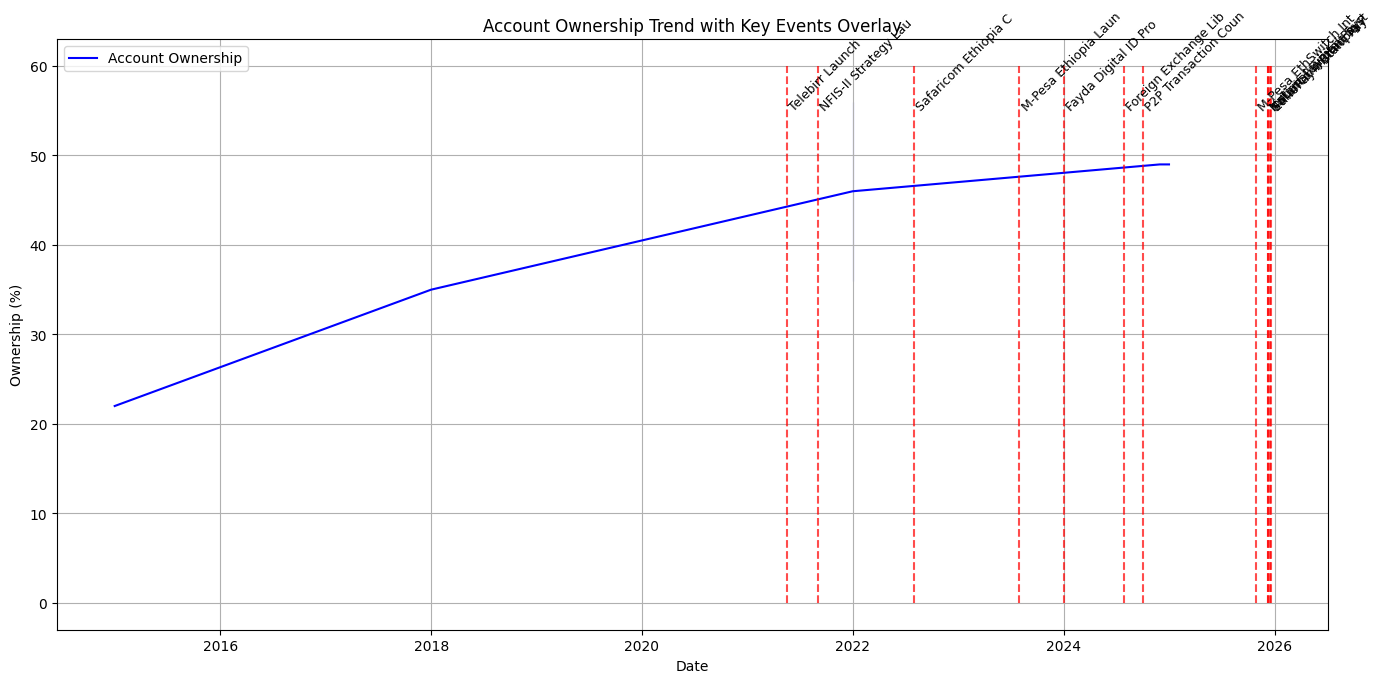

In [11]:
events = df[df['record_type'] == 'event'].copy()
events['observation_date'] = pd.to_datetime(events['observation_date'], errors='coerce')

plt.figure(figsize=(14, 7))
sns.lineplot(data=acc_own, x='observation_date', y='value_numeric', color='blue', label='Account Ownership')
plt.vlines(events['observation_date'], ymin=0, ymax=60, color='red', linestyle='--', alpha=0.7)

for i, row in events.iterrows():
    plt.text(row['observation_date'], 55, row['indicator'][:20], rotation=45, fontsize=9)

plt.title('Account Ownership Trend with Key Events Overlay')
plt.ylabel('Ownership (%)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, 'event_timeline_overlay.png'))
plt.show()

In [12]:
insights = """
### Key Insights from EDA

1. **Slowdown in access growth**: Account ownership increased +3pp only from 2021 to 2024 (46% → 49%), despite massive mobile money registration — indicates low activation/usage.

2. **Persistent gender gap**: Women at 42% vs men 57% in 2024 (~15pp gap unchanged since 2021) — structural barriers (literacy, phone ownership, norms) remain.

3. **Mobile money growth but active usage low**: From 4.7% (2021) to ~19.4% (2025 est.), but NDPS highlights only ~15% active — registered vs active gap is critical challenge.

4. **Digital payments lag access**: Only 21% made/received digital payment in 2024 — P2P dominance, limited merchant acceptance, low trust/utility.

5. **Infrastructure as leading indicator**: Mobile connections 68.4% and internet 21.7% in late 2025 correlate strongly with access growth — but affordability/digital literacy bottlenecks persist.

6. **Event impact potential**: NDPS (Dec 2025) and IPS launch expected to boost usage significantly (high magnitude, 12-month lag) — interoperability key.

Evidence: Findex 2025, DataReportal 2026, NDPS document, enriched dataset analysis.
"""

insights_path = os.path.join(PROJECT_ROOT, 'reports', 'key_insights.md')
with open(insights_path, 'w', encoding='utf-8') as f:
    f.write(insights)

print("Key insights saved to:", insights_path)

Key insights saved to: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\reports\key_insights.md


In [13]:
print("EDA complete. Figures saved in:", REPORTS_DIR)
print("Key insights saved in reports/key_insights.md")
print("\nTask 2 ready for commit.")

EDA complete. Figures saved in: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\reports\figures
Key insights saved in reports/key_insights.md

Task 2 ready for commit.
